<a href="https://colab.research.google.com/github/iandreafc/sna-bigdata-course/blob/master/Shap/ShapTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python SHAP Model Interpretation
Adapted from the SHAP repository.

In [0]:
#For Google Colab
!pip install shap
!pip install catboost
!pip install xgboost

In [4]:
#pip install --upgrade shap
import shap

import catboost
from catboost import *

#for the first model
import xgboost

import pandas as pd
import numpy as np

shap.initjs() #to enable visualization

Let's first explore shap values for dataset with numeric features. **In this tutorial we do not focus on best/correct model training**.

In [0]:
#NHANES mortality data
X,y = shap.datasets.nhanesi()
X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values

#XGBoost matrix
xgb_full = xgboost.DMatrix(X, label=y)

In [6]:
#Train XGBoost Model on FULL DATASET
#!Same dataset is also used for early stopping
#Train final model on the FULL data set
#Cox-survival objective function
params = {
    "eta": 0.002,
    "max_depth": 3, 
    "objective": "survival:cox",
    "subsample": 0.5
}
model = xgboost.train(params, xgb_full, 5000, evals = [(xgb_full, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:8.88081
[1000]	test-cox-nloglik:8.1673
[2000]	test-cox-nloglik:8.07806
[3000]	test-cox-nloglik:8.03906
[4000]	test-cox-nloglik:8.01412
[4999]	test-cox-nloglik:7.99296


#### Calculate Shap Values

In [7]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### Explain Single Predictions

In [11]:
#For Google Colab
shap.initjs()

# Force Plot of first prediction
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

The same can be visualized through a waterfall plot

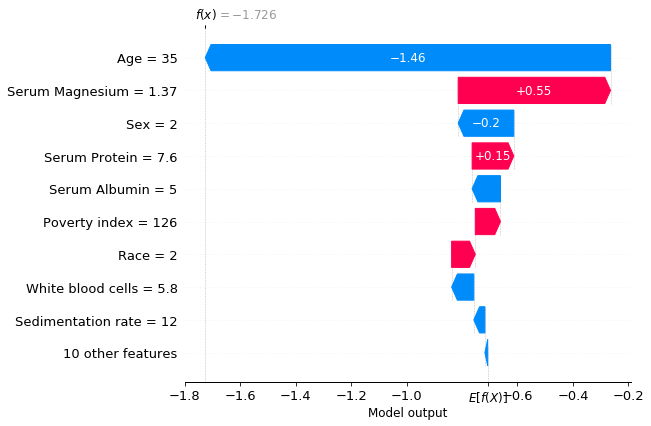

In [12]:
# Waterfall Plot
shap.waterfall_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

Can also be done with decision plots (feature values for the specific observation are also reported).

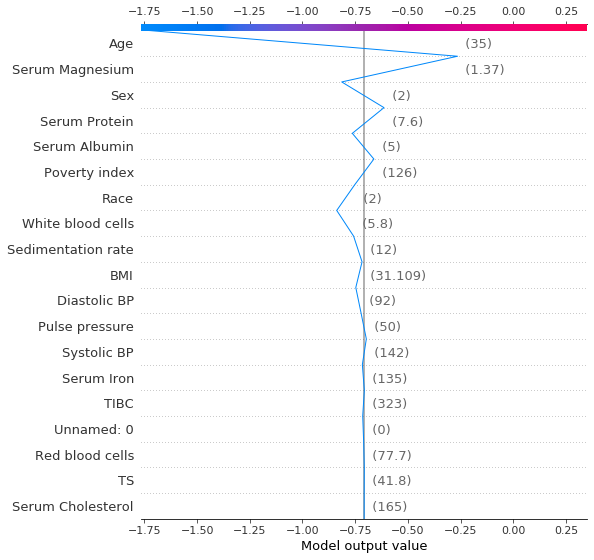

In [13]:
shap.decision_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

### Global Importance
To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. 

The SHAP values for XGBoost explain the margin output of the model, which is the change in log odds of dying for a Cox proportional hazards model. We can see below that the primary risk factor for death according to the model is being old. The next most powerful indicator of death risk is being a man.

This summary plot replaces the typical bar chart of feature importance. It tells which features are most important, and also their range of effects over the dataset. The color allows us match how changes in the value of a feature effect the change in risk (such that a high white blood cell count leads to a high risk of death).

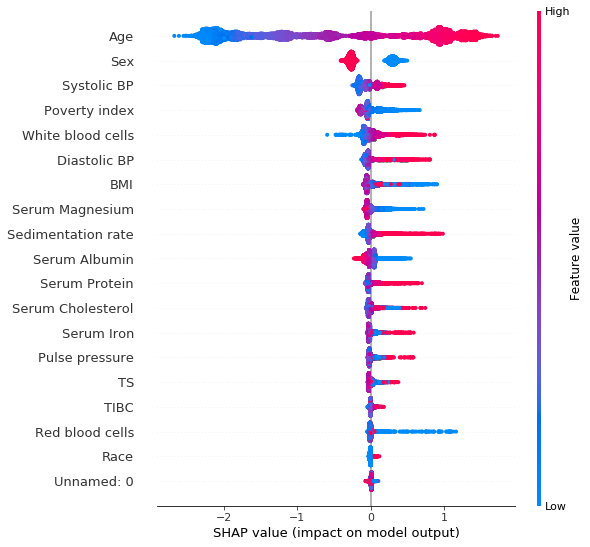

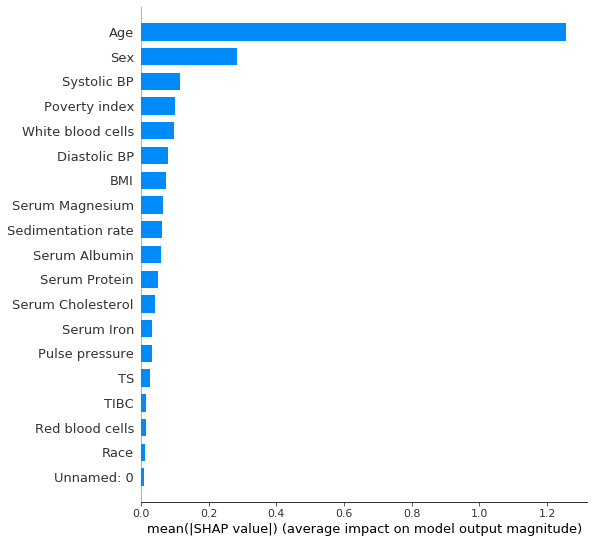

In [14]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X, plot_type = "bar")

### Decision Plots
Shows the impact of each feature on each prediction path. **hclust** ordering often provides better visualization.

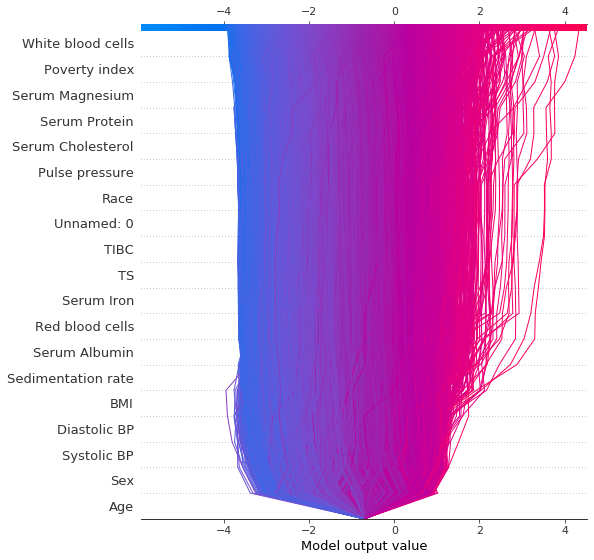

In [15]:
#Use ignore_warnings=True to plot many observations (may be slow)
shap.decision_plot(explainer.expected_value, shap_values, X, feature_order='hclust', ignore_warnings=True) 

### Dependence Plots
While a SHAP summary plot gives a general overview of each feature a SHAP dependence plot show how the model output varies by feauture value. Note that every dot is a person, and the vertical dispersion at a single feature value results from interaction effects in the model. The feature used for coloring is automatically chosen to highlight what might be driving these interactions. Later we will see how to check that the interaction is really in the model with SHAP interaction values. 

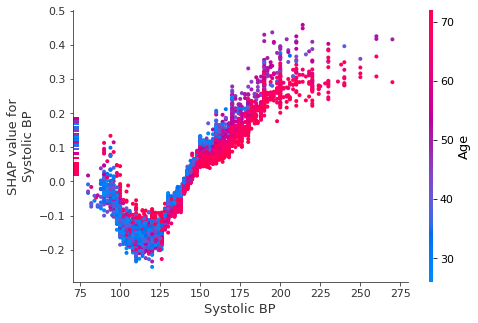

In [0]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Systolic BP", shap_values, X)

### Inteaction Plots
The main effect is separated from the interactions (this is the reason why in the main effect graph there is little vertical dispersion).

In [0]:
#Calculate SHAP interaction values (Catboost still has a problem with this)
#Can be very slow
shap_interaction_values = explainer.shap_interaction_values(X)

In [0]:
#Main
shap.dependence_plot(
    ("Age", "Age"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [0]:
#Interaction
shap.dependence_plot(("Age", "Systolic BP"), shap_interaction_values, X) 

In [0]:
#Interaction
shap.dependence_plot(("Age", "Sex"), shap_interaction_values, X) 

## With Categorical Features
You can also use shap values to analyze importance of categorical features. Here we use **Catboost**.

In [0]:
#Use Titanic data (binary, survived or not)
df = pd.read_csv("titanic.csv")
y = df.Survived
X = df.drop('Survived', axis=1)

#Replace NANs
df.fillna(-999, inplace=True)

#Encode strings
for var in ['Sex', 'Cabin', 'Embarked']:
    X[var] = X[var].astype('category').cat.codes
X.head()

In [0]:
print(X.dtypes)
cat_features = np.where(X.dtypes != np.float)[0]
cat_features

In [0]:
model = CatBoostClassifier(random_seed=14)
model.fit(X, y, cat_features=cat_features, verbose=False, plot=False)

In [0]:
#When the SHAP Explainer has problems
#explainer = shap.TreeExplainer(model)
#shap_values = explainer.shap_values(Pool(X, y, cat_features=cat_features))

#Use Catboost to calculate Shap Values
pool = Pool(X, label=y, cat_features = cat_features)
shap_values = model.get_feature_importance(type="ShapValues", data = pool)
shap_values = shap_values[:,:-1]
shap_values_df = pd.DataFrame(shap_values, columns=X.columns.values)


Explain single predictions.

In [0]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In the summary plot below you can see that absolute values of the features do not matter (when categorical). But it is clear from the plot what is the effect of different features.

In [0]:
shap.summary_plot(shap_values, X)

## Multiclass Examples

In [0]:
model = CatBoostClassifier(loss_function = 'MultiClass', random_seed=14)
model.fit(X, y, cat_features=cat_features, verbose=False, plot=False)

In [0]:
#explainer = shap.TreeExplainer(model)
#shap_values = explainer.shap_values(Pool(X, y, cat_features=cat_features))

#When SHAP explainer gives errors
shap_values = model.get_feature_importance(type="ShapValues", data = pool)
shap_values = shap_values.transpose(1,0,2)
shap_values = list(shap_values[:,:,:-1])
shap_values_df = pd.DataFrame(np.sum([np.mean(np.absolute(x), axis=0) for x in shap_values], axis=0)).T
shap_values_df.columns = X.columns.values

Summary plot of SHAP values for formula raw predictions for class 0.

In [0]:
shap.summary_plot(shap_values[0], X)

And for class 1.

In [0]:
shap.summary_plot(shap_values[1], X)

Or together.

In [0]:
shap.summary_plot(shap_values, X)